# Reinplementation of Block Coordinate Descent (BCD) Algorithm for Training DNNs (3-layer MLP) for MNIST in PyTorch

## Import libraries

In [1]:
"""
5 runs, seed = 10, 20, 30, 40, 50; 
validation accuracies: 0.9541, 0.9551, 0.9558, 0.9553, 0.9564
"""
from __future__ import print_function, division
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy

# print("PyTorch Version: ",torch.__version__)
# print("Torchvision Version: ",torchvision.__version__)

## Read in MNIST dataset

In [2]:
dtype = torch.float
device = torch.device("cpu") # Uncomment this to run on CPU
# device = torch.device("cuda:0") 

ts = transforms.Compose([transforms.ToTensor(), # Convert to tensor and scale to [0, 1]
                             transforms.Normalize((0,), (1,))])
mnist_trainset = datasets.MNIST('../data', train=True, download=True,
                       transform=ts)
mnist_testset = datasets.MNIST(root='../data', train=False, download=True, 
                        transform=ts)

## Data manipulation

In [3]:
# Manipulate train set
x_d1 = mnist_trainset[0][0].size()[1]
x_d2 = mnist_trainset[0][0].size()[2]
N = x_d3 = len(mnist_trainset)
K = 10
x_train = torch.empty((N,x_d1*x_d2), device=device)
y_train = torch.empty(N, dtype=torch.long)
for i in range(N): 
     x_train[i,:] = torch.reshape(mnist_trainset[i][0], (1,x_d1*x_d2))
     y_train[i] = mnist_trainset[i][1]
x_train = torch.t(x_train)
y_one_hot = torch.zeros(N, K).scatter_(1, torch.reshape(y_train,(N,1)), 1)
y_one_hot = torch.t(y_one_hot).to(device=device)

# Manipulate test set
x_d1_test = mnist_testset[0][0].size()[1]
x_d2_test = mnist_testset[0][0].size()[2]
N_test = x_d3_test = len(mnist_testset)
x_test = torch.empty((10000,784), device=device)
y_test = torch.empty(10000, dtype=torch.long)
for i in range(10000): 
     x_test[i,:] = torch.reshape(mnist_testset[i][0], (1,28*28))
     y_test[i] = mnist_testset[i][1]
x_test = torch.t(x_test)
y_test_one_hot = torch.zeros(N_test, K).scatter_(1, torch.reshape(y_test,(N_test,1)), 1)
y_test_one_hot = torch.t(y_test_one_hot).to(device=device)

## Main algorithm (Jinshan's Algorithm in Zeng et al (2018))

### Parameter initialization

In [4]:
torch.manual_seed(50)
d0 = x_d1*x_d2
d1 = d2 = d3 = 2048
d4 = K # Layers: input + 3 hidden + output
W1 = 0.01*torch.randn(d1, d0, device=device)
b1 = 0.1*torch.ones(d1, 1, device=device)
W2 = 0.01*torch.randn(d2, d1, device=device)
b2 = 0.1*torch.ones(d2, 1, device=device)
W3 = 0.01*torch.randn(d3, d2, device=device)
b3 = 0.1*torch.ones(d3, 1, device=device)
W4 = 0.01*torch.randn(d4, d3, device=device)
b4 = 0.1*torch.ones(d4, 1, device=device)

U1 = torch.addmm(b1.repeat(1, N), W1, x_train)
V1 = nn.ReLU()(U1)
U2 = torch.addmm(b2.repeat(1, N), W2, V1)
V2 = nn.ReLU()(U2)
U3 = torch.addmm(b3.repeat(1, N), W3, V2)
V3 = nn.ReLU()(U3) 
U4 = torch.addmm(b4.repeat(1, N), W4, V3)
V4 = U4

gamma = 1
gamma1 = gamma2 = gamma3 = gamma4 = gamma

rho = gamma
rho1 = rho2 = rho3 = rho4 = rho


alpha = 5
alpha1 = alpha2 = alpha3 = alpha4 = alpha5 = alpha6 = alpha7 \
= alpha8 = alpha9 = alpha10 = alpha

niter = 30
loss1 = np.empty(niter)
loss2 = np.empty(niter)
layer1 = np.empty(niter)
layer2 = np.empty(niter)
layer3 = np.empty(niter)
layer4 = np.empty(niter)
layer11 = np.empty(niter)
layer21 = np.empty(niter)
layer31 = np.empty(niter)
layer41 = np.empty(niter)
accuracy_train = np.empty(niter)
accuracy_test = np.empty(niter)
time1 = np.empty(niter)

### Define functions for updating blocks

In [5]:
def updateV_js(U1,U2,W,b,rho,gamma): 
    _, d = W.size()
    I = torch.eye(d, device=device)
    U1 = nn.ReLU()(U1)
    _, col_U2 = U2.size()
    Vstar = torch.mm(torch.inverse(rho*(torch.mm(torch.t(W),W))+gamma*I), rho*torch.mm(torch.t(W),U2-b.repeat(1,col_U2))+gamma*U1)
    return Vstar

In [6]:
def updateWb_js(U, V, W, b, alpha, rho): 
    d,N = V.size()
    I = torch.eye(d, device=device)
    _, col_U = U.size()
    Wstar = torch.mm(alpha*W+rho*torch.mm(U-b.repeat(1,col_U),torch.t(V)),torch.inverse(alpha*I+rho*(torch.mm(V,torch.t(V)))))
    bstar = (alpha*b+rho*torch.sum(U-torch.mm(W,V), dim=1).reshape(b.size()))/(rho*N+alpha)
    return Wstar, bstar

### Define the proximal operator of the ReLU activation function

In [7]:
def relu_prox(a, b, gamma, d, N):
    val = torch.empty(d,N, device=device)
    x = (a+gamma*b)/(1+gamma)
    y = torch.min(b,torch.zeros(d,N, device=device))

    val = torch.where(a+gamma*b < 0, y, torch.zeros(d,N, device=device))
    val = torch.where(((a+gamma*b >= 0) & (b >=0)) | ((a*(gamma-np.sqrt(gamma*(gamma+1))) <= gamma*b) & (b < 0)), x, val)
    val = torch.where((-a <= gamma*b) & (gamma*b <= a*(gamma-np.sqrt(gamma*(gamma+1)))), b, val)
    return val

### Training algorithm

In [8]:
# Iterations
for k in range(niter):
    start = time.time()
     # record previous W1, W2, W3, W4, b1, b2, b3, b4
    W10 = W1
    W20 = W2
    W30 = W3
    W40 = W4
    b10 = b1
    b20 = b2
    b30 = b3
    b40 = b4

    # update V4
    V4 = (y_one_hot + gamma4*U4 + alpha1*V4)/(1 + gamma4 + alpha1)
    
    # update U4 
    U4 = (gamma4*V4 + rho4*(torch.mm(W4,V3) + b4.repeat(1,N)))/(gamma4 + rho4)

    # update W4 and b4
    W4, b4 = updateWb_js(U4,V3,W4,b4,alpha2,rho4)
    
    # update V3
    V3 = updateV_js(U3,U4,W4,b4,rho4,gamma3)
    
    # update U3
    U3 = relu_prox(V3,(rho3*torch.addmm(b3.repeat(1,N), W3, V2) + alpha3*U3)/(rho3 + alpha3),(rho3 + alpha3)/gamma3,d3,N)
    
    # update W3 and b3
    W3, b3 = updateWb_js(U3,V2,W3,b3,alpha4,rho3)
    
    # update V2
    V2 = updateV_js(U2,U3,W3,b3,rho3,gamma2)
    
    # update U2
    U2 = relu_prox(V2,(rho2*torch.addmm(b2.repeat(1,N), W2, V1) + alpha5*U2)/(rho2 + alpha5),(rho2 + alpha5)/gamma2,d2,N)
    
    # update W2 and b2
    W2, b2 = updateWb_js(U2,V1,W2,b2,alpha6,rho2)

    # update V1
    V1 = updateV_js(U1,U2,W2,b2,rho2,gamma1)
    
    # update U1
    U1 = relu_prox(V1,(rho1*torch.addmm(b1.repeat(1,N), W1, x_train) + alpha7*U1)/(rho1 + alpha7),(rho1 + alpha7)/gamma1,d1,N)

    # update W1 and b1
    W1, b1 = updateWb_js(U1,x_train,W1,b1,alpha8,rho1)

    a1_train = nn.ReLU()(torch.addmm(b1.repeat(1, 60000), W1, x_train))
    a2_train = nn.ReLU()(torch.addmm(b2.repeat(1, 60000), W2, a1_train))
    a3_train = nn.ReLU()(torch.addmm(b3.repeat(1, 60000), W3, a2_train))
    pred = torch.argmax(torch.addmm(b4.repeat(1, 60000), W4, a3_train), dim=0)

    a1_test = nn.ReLU()(torch.addmm(b1.repeat(1, 10000), W1, x_test))
    a2_test = nn.ReLU()(torch.addmm(b2.repeat(1, 10000), W2, a1_test))
    a3_test = nn.ReLU()(torch.addmm(b3.repeat(1, 10000), W3, a2_test))
    pred_test = torch.argmax(torch.addmm(b4.repeat(1, 10000), W4, a3_test), dim=0)
    
    loss1[k] = gamma4/2*torch.pow(torch.dist(V4,y_one_hot,2),2).cpu().numpy()
    loss2[k] = loss1[k] + rho1/2*torch.pow(torch.dist(torch.addmm(b1.repeat(1,N), W1, x_train),U1,2),2).cpu().numpy() \
    +rho2/2*torch.pow(torch.dist(torch.addmm(b2.repeat(1,N), W2, V1),U2,2),2).cpu().numpy() \
    +rho3/2*torch.pow(torch.dist(torch.addmm(b3.repeat(1,N), W3, V2),U3,2),2).cpu().numpy() \
    +rho4/2*torch.pow(torch.dist(torch.addmm(b4.repeat(1,N), W4, V3),U4,2),2).cpu().numpy()
    
    correct_train = pred == y_train
    accuracy_train[k] = np.mean(correct_train.cpu().numpy())
    correct_test = pred_test == y_test
    accuracy_test[k] = np.mean(correct_test.cpu().numpy())
    stop = time.time()
    duration = stop-start
    time1[k] = duration
    print('Epoch:', k, ',', 'squared loss:', loss1[k], ',', 'total loss:', loss2[k], ',', 'training accuracy:', \
          accuracy_train[k], ',', 'validation accuracy:', accuracy_test[k], ',', 'time:', time1[k])

Epoch: 0 , squared loss: 20131.158203125 , total loss: 20153.119740101974 , training accuracy: 0.5842166666666667 , validation accuracy: 0.5816 , time: 65.0657057762146
Epoch: 1 , squared loss: 15162.9033203125 , total loss: 15172.447250099853 , training accuracy: 0.8469166666666667 , validation accuracy: 0.8459 , time: 64.8881733417511
Epoch: 2 , squared loss: 11660.166015625 , total loss: 11666.232872935943 , training accuracy: 0.9019833333333334 , validation accuracy: 0.9048 , time: 64.60323882102966
Epoch: 3 , squared loss: 9017.4794921875 , total loss: 9022.219353240915 , training accuracy: 0.9200333333333334 , validation accuracy: 0.9198 , time: 68.33290982246399
Epoch: 4 , squared loss: 6977.7626953125 , total loss: 6984.065168727189 , training accuracy: 0.9291333333333334 , validation accuracy: 0.9281 , time: 68.93849778175354
Epoch: 5 , squared loss: 5419.50830078125 , total loss: 5424.001744959503 , training accuracy: 0.9338833333333333 , validation accuracy: 0.9335 , time: 6

### Visualization of training results

Text(0.5,1,'validation accuracy')

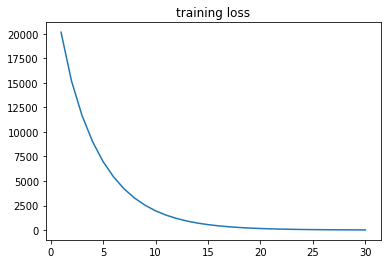

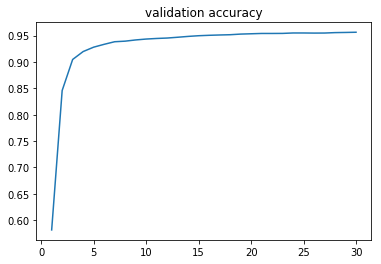

In [10]:
plt.figure()
plt.plot(np.arange(1,niter+1), loss2)
plt.title('training loss')

plt.figure()
plt.plot(np.arange(1,niter+1), accuracy_test)
plt.title('validation accuracy')